In [46]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.utils import plot_model
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential 
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop , Adam
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error , mean_absolute_error , mean_absolute_percentage_error
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM , Dense , Dropout , GRU , Concatenate , Input , Conv1D , InputLayer , Flatten
from tensorflow.keras import models
from tensorflow.keras.callbacks import EarlyStopping
import math

In [47]:
df_btc = pd.read_csv("BTC_1h_data.csv")

<Strong> Grabbing the closing price (univariate) </Strong>

In [48]:
btc_data = df_btc.values[:, 4 ,].astype(float)

<Strong> Scaling the data  </Strong>

In [49]:
percTrain = 70
percVal = 20 

In [50]:
scaler = MinMaxScaler()
    
onePercent = len(btc_data) // 100
numberTraining = onePercent * percTrain

reshaped_data = btc_data.reshape(-1,1)

#Just scaling on training data otherwise it would be leakage
scaler.fit(reshaped_data[:numberTraining])
scaled_btc = scaler.transform(reshaped_data)

<Strong> Hyper-parameters </Strong>

In [51]:
# Hyper Parameters 

# How many hidden layers we should have 
# Learning rate
# Kernel Size
# Window Size
#Filters

window_length = 24
features = 1

<Strong> Creating Matrix in Sliding window form <Strong>

In [52]:
def sliding_window(elements, window_size):
    
    data = [] 
    targets = []
    
    if len(elements) <= window_size:
        return elements
    
    for i in range(len(elements) - window_size ):
        
        data.append(elements[i:i+window_size])
        targets.append(elements[i+window_size])
        
    return np.array(data) , np.array(targets)

sliding_winda_btc = sliding_window(scaled_btc , window_length)

<Strong> Splitting the data into train , val , test </Strong>

In [53]:
# Splitting the data after creating the sliding window data
def splitting_train_test(data):
        
    onePercent = len(data[1]) // 100
    
    numberTraining = onePercent * percTrain
    numberValidation = onePercent * percVal
    
    trainingData = data[0][:numberTraining] , data[1][:numberTraining]
    validationData = data[0][numberTraining : numberTraining + numberValidation] , data[1][numberTraining : numberTraining + numberValidation]
    testData = data[0][numberTraining + numberValidation:] , data[1][numberTraining + numberValidation:] 
    
    #Returning tuples of (sliding-window , target_values)
    return trainingData , validationData , testData

btc_train , btc_val , btc_test = splitting_train_test(sliding_winda_btc)

<Strong> The number of layers while changing dilation_base , kernel_size or window_size. </Strong>

In [54]:
def getLayers(dilation_rate , window_size , kernel_size):
    
    top = (dilation_rate - 1) * (window_size - 1)
    bottom = (kernel_size - 1) 
    
    division = (top / bottom) + 1 
    log = math.ceil(math.log(division , dilation_rate))
    
    
    # This inequality must hold true for full coverage
    
    first = 1 + (kernel_size - 1)
    second = (dilation_rate ** log ) - 1
    third = dilation_rate - 1
    
    inequality = (second / third) * first
    
    if ( (kernel_size < dilation_rate) or (inequality < window_size) ):
        print("not going to have full coverage")
        return False
    
    else:
        print("layers =" , log , "dilation rate =" , dilation_rate , "kernel size =" , kernel_size , )
        return log , dilation_rate , kernel_size

getLayers( 2 , 24 , 4)

layers = 4 dilation rate = 2 kernel size = 4


(4, 2, 4)

<Strong> Second 4-Layer Model with <i> dilation_rate = 2 </i> and <i> kernel_size = 4 </i> </Strong>

<Strong> Window length 120  </Strong>

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 120, 32)           160       
                                                                 
 conv1d_13 (Conv1D)          (None, 120, 32)           4128      
                                                                 
 conv1d_14 (Conv1D)          (None, 120, 32)           4128      
                                                                 
 conv1d_15 (Conv1D)          (None, 120, 32)           4128      
                                                                 
 flatten_3 (Flatten)         (None, 3840)              0         
                                                                 
 dense_6 (Dense)             (None, 32)                122912    
                                                                 
 dense_7 (Dense)             (None, 1)                

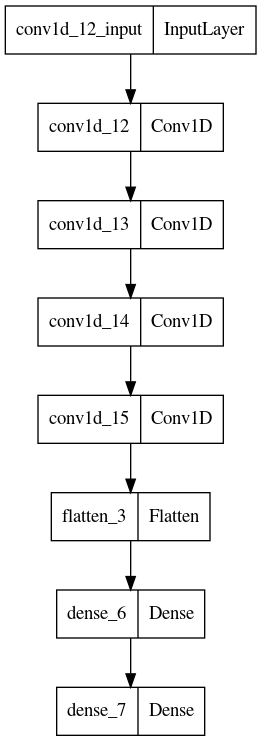

In [42]:
model = models.Sequential()

model.add(Conv1D(filters= 32, kernel_size=4, activation='relu', input_shape=(window_length, 1), dilation_rate=1 , padding = 'causal'))
model.add(Conv1D(filters= 32, kernel_size=4, activation='relu' , padding = 'causal', dilation_rate=2))
model.add(Conv1D(filters= 32, kernel_size=4, activation='relu' , padding = 'causal' , dilation_rate=4))
model.add(Conv1D(filters= 32, kernel_size=4, activation='relu' , padding = 'causal' , dilation_rate=8))
model.add(Flatten())

model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.summary()
display(plot_model(model))
    
opt = Adam(learning_rate=0.002)
model.compile(optimizer=opt , loss = 'mse')

In [43]:

earlyStopping = EarlyStopping(monitor = 'val_loss' , patience = 30 , mode = 'min' , verbose = 1)
history = model.fit(btc_train[0] , btc_train[1] , validation_data = btc_val  , batch_size = 512  , epochs =300 , verbose = 1 , callbacks=[earlyStopping])
num_epochs = earlyStopping.stopped_epoch


Epoch 1/300
54/54 [==============================] - 5s 89ms/step - loss: 0.0116 - val_loss: 0.0209
Epoch 2/300
54/54 [==============================] - 5s 87ms/step - loss: 8.6966e-04 - val_loss: 0.0135
Epoch 3/300
54/54 [==============================] - 5s 86ms/step - loss: 6.1157e-04 - val_loss: 0.0102
Epoch 4/300
54/54 [==============================] - 5s 86ms/step - loss: 5.3902e-04 - val_loss: 0.0192
Epoch 5/300
54/54 [==============================] - 5s 86ms/step - loss: 4.5171e-04 - val_loss: 0.0258
Epoch 6/300
54/54 [==============================] - 6s 103ms/step - loss: 4.3629e-04 - val_loss: 0.0181
Epoch 7/300
54/54 [==============================] - 5s 87ms/step - loss: 3.4723e-04 - val_loss: 0.0119
Epoch 8/300
54/54 [==============================] - 5s 87ms/step - loss: 3.0892e-04 - val_loss: 0.0089
Epoch 9/300
54/54 [==============================] - 5s 88ms/step - loss: 2.1086e-04 - val_loss: 0.0038
Epoch 10/300
54/54 [==============================] - 5s 88ms/step 

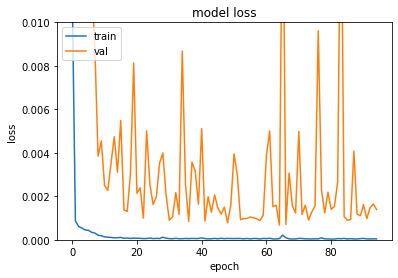

In [45]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim([0,0.01])
plt.show()

<Strong> First 4-Layer Model with <i> dilation_rate = 2 </i> and <i> kernel_size = 3 </i> </Strong>

<Strong> Window Length 24 </Strong>

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 24, 16)            64        
                                                                 
 conv1d_17 (Conv1D)          (None, 24, 16)            784       
                                                                 
 conv1d_18 (Conv1D)          (None, 24, 16)            784       
                                                                 
 conv1d_19 (Conv1D)          (None, 24, 16)            784       
                                                                 
 flatten_4 (Flatten)         (None, 384)               0         
                                                                 
 dense_8 (Dense)             (None, 64)                24640     
                                                                 
 dense_9 (Dense)             (None, 1)                

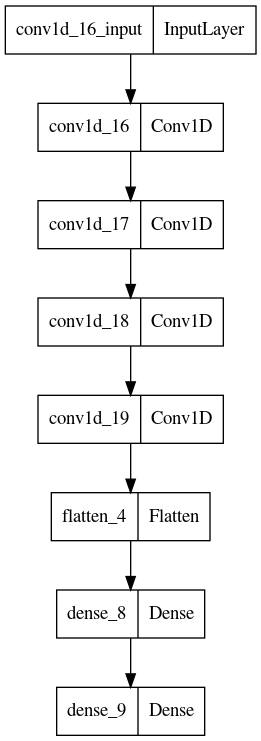

In [55]:

model = models.Sequential()

model.add(Conv1D(filters= 16, kernel_size=3, activation='relu', input_shape=(window_length, 1), dilation_rate=1 , padding = 'causal'))
model.add(Conv1D(filters= 16, kernel_size=3, activation='relu' , padding = 'causal', dilation_rate=2))
model.add(Conv1D(filters= 16 , kernel_size=3, activation='relu' , padding = 'causal' , dilation_rate=4))
model.add(Conv1D(filters= 16 , kernel_size=3, activation='relu' , padding = 'causal' , dilation_rate=8))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dense(1))

model.summary()
display(plot_model(model))
    
opt = Adam(learning_rate=0.006)
model.compile(optimizer=opt , loss = 'mse')




In [56]:

earlyStopping = EarlyStopping(monitor = 'val_loss' , patience = 30 , mode = 'min' , verbose = 1)
history = model.fit(btc_train[0] , btc_train[1] , validation_data = btc_val  , batch_size = 512  , epochs =300 , verbose = 1 , callbacks=[earlyStopping])
num_epochs = earlyStopping.stopped_epoch



Epoch 1/300
54/54 [==============================] - 1s 18ms/step - loss: 0.0072 - val_loss: 0.0113
Epoch 2/300
54/54 [==============================] - 1s 15ms/step - loss: 3.9100e-04 - val_loss: 0.0078
Epoch 3/300
54/54 [==============================] - 1s 16ms/step - loss: 3.5381e-04 - val_loss: 0.0109
Epoch 4/300
54/54 [==============================] - 1s 15ms/step - loss: 3.2593e-04 - val_loss: 0.0113
Epoch 5/300
54/54 [==============================] - 1s 15ms/step - loss: 2.9826e-04 - val_loss: 0.0112
Epoch 6/300
54/54 [==============================] - 1s 16ms/step - loss: 2.7731e-04 - val_loss: 0.0093
Epoch 7/300
54/54 [==============================] - 1s 16ms/step - loss: 2.5312e-04 - val_loss: 0.0150
Epoch 8/300
54/54 [==============================] - 1s 15ms/step - loss: 2.3191e-04 - val_loss: 0.0075
Epoch 9/300
54/54 [==============================] - 1s 15ms/step - loss: 2.1514e-04 - val_loss: 0.0056
Epoch 10/300
54/54 [==============================] - 1s 15ms/step -

In [ ]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim([0,0.01])
plt.show()